# **A. Import Libraries**

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Normalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

from scipy import stats
import pandas as pd
import numpy as np

import pathlib
import pprint
import tempfile


# **B. Data Processing**

In [ ]:
colum_names = pd.read_csv('https://raw.githubusercontent.com/annyper/Bicycle_Thefts/main/Student%20data.csv', nrows=18).transpose().head(1)
colum_names

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
Student Data,Independent variables,First Term Gpa' numeric,Second Term Gpa' numeric,First Language' numeric,Funding numeric,School numeric,FastTrack numeric,Coop numeric,Residency numeric,Gender numeric,Previous Education' numeric,Age Group' numeric,High School Average Mark' numeric,Math Score' numeric,English Grade' numeric,NaN,Dependent variable,"FirstYearPersistence {1,0}"


In [ ]:
colum_names=colum_names.drop(columns=[0,15,16])
colum_names=colum_names.squeeze()
colum_names=colum_names.str.replace('numeric', '', regex=True)
colum_names=colum_names.str.replace('\'', '', regex=True)
colum_names=colum_names.str.replace(' ', '', regex=True)
colum_names=colum_names.str.replace('\{1,0\}', '', regex=True)
colum_names = list(colum_names)
colum_names

['FirstTermGpa',
 'SecondTermGpa',
 'FirstLanguage',
 'Funding',
 'School',
 'FastTrack',
 'Coop',
 'Residency',
 'Gender',
 'PreviousEducation',
 'AgeGroup',
 'HighSchoolAverageMark',
 'MathScore',
 'EnglishGrade',
 'FirstYearPersistence']

In [ ]:
# Class Names
class_names = ['FirstTermGpa', 'SecondTermGpa', 'FirstLanguage', 'Funding', 'School', 'FastTrack', 'Coop', 'Residency', 'Gender', 'PreviousEducation', 'AgeGroup', 'HighSchoolAverageMark', 'MathScore', 'EnglishGrade', 'FirstYearPersistence']
class_names_categorical = ['FirstLanguage', 'Funding', 'School', 'FastTrack', 'Coop', 'Residency', 'Gender', 'PreviousEducation', 'AgeGroup']
class_names_numerical = ['FirstTermGpa', 'SecondTermGpa', 'HighSchoolAverageMark', 'MathScore', 'EnglishGrade']
label_dict = {'FirstYearPersistence_no': 0, 'FirstYearPersistence_yes': 1}


In [ ]:
students_ds = pd.read_csv('https://raw.githubusercontent.com/annyper/Bicycle_Thefts/main/Student%20data.csv',skiprows=24, names=colum_names)
students_ds = students_ds.replace('?', np.nan)
students_ds

,FirstTermGpa,SecondTermGpa,FirstLanguage,Funding,School,FastTrack,Coop,Residency,Gender,PreviousEducation,AgeGroup,HighSchoolAverageMark,MathScore,EnglishGrade,FirstYearPersistence
0,0,0,1,2,6,2,1,1,2,1,1,59,16,7,1
1,2.5,2,3,4,6,1,2,2,2,1,3,NaN,NaN,7,1
2,4.25,3.923077,1,1,6,2,1,1,1,2,3,92,41,9,1
3,3.020833,2.321429,3,4,6,1,2,2,2,2,3,NaN,NaN,8,1
4,4.275,4.326923,1,2,6,1,1,1,1,2,3,97,NaN,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1432,1.413043,0,NaN,4,6,2,2,2,2,1,1,NaN,47,10,0
1433,4.36,4.074074,1,2,6,1,1,1,1,2,4,NaN,NaN,10,1
1434,2.020833,2.45,1,2,6,2,1,1,2,1,1,78,18,9,1
1435,4.021739,4.357143,NaN,4,6,2,1,2,1,1,2,NaN,46,8,1


In [ ]:
students_ds=students_ds.astype('float64')

scaler = StandardScaler()
scaler.fit(students_ds)
ds_mean = scaler.mean_
ds_mode = np.array(students_ds.mode())[0]
ds_std = scaler.scale_
students_ds.dtypes

FirstTermGpa             float64
SecondTermGpa            float64
FirstLanguage            float64
Funding                  float64
School                   float64
FastTrack                float64
Coop                     float64
Residency                float64
Gender                   float64
PreviousEducation        float64
AgeGroup                 float64
HighSchoolAverageMark    float64
MathScore                float64
EnglishGrade             float64
FirstYearPersistence     float64
dtype: object

In [ ]:
# Define feature columns
feature_columns = [
    tf.feature_column.numeric_column("FirstTermGpa"),
    tf.feature_column.numeric_column("SecondTermGpa"),
    tf.feature_column.categorical_column_with_identity("FirstLanguage", num_buckets=3),
    tf.feature_column.categorical_column_with_identity("Funding", num_buckets=9),
    tf.feature_column.categorical_column_with_identity("School", num_buckets=6),
    tf.feature_column.categorical_column_with_identity("FastTrack", num_buckets=2),
    tf.feature_column.categorical_column_with_identity("Coop", num_buckets=2),
    tf.feature_column.categorical_column_with_identity("Residency", num_buckets=2),
    tf.feature_column.categorical_column_with_identity("Gender", num_buckets=2),
    tf.feature_column.categorical_column_with_identity("PreviousEducation", num_buckets=3),
    tf.feature_column.categorical_column_with_identity("AgeGroup", num_buckets=8),
    tf.feature_column.numeric_column("HighSchoolAverageMark"),
    tf.feature_column.numeric_column("MathScore"),
    tf.feature_column.numeric_column("EnglishGrade")
]

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [ ]:
tensor = tf.convert_to_tensor(students_ds.values)
ds = tf.data.Dataset.from_tensor_slices(dict(students_ds))
ds

<_TensorSliceDataset element_spec={'FirstTermGpa': TensorSpec(shape=(), dtype=tf.float64, name=None), 'SecondTermGpa': TensorSpec(shape=(), dtype=tf.float64, name=None), 'FirstLanguage': TensorSpec(shape=(), dtype=tf.float64, name=None), 'Funding': TensorSpec(shape=(), dtype=tf.float64, name=None), 'School': TensorSpec(shape=(), dtype=tf.float64, name=None), 'FastTrack': TensorSpec(shape=(), dtype=tf.float64, name=None), 'Coop': TensorSpec(shape=(), dtype=tf.float64, name=None), 'Residency': TensorSpec(shape=(), dtype=tf.float64, name=None), 'Gender': TensorSpec(shape=(), dtype=tf.float64, name=None), 'PreviousEducation': TensorSpec(shape=(), dtype=tf.float64, name=None), 'AgeGroup': TensorSpec(shape=(), dtype=tf.float64, name=None), 'HighSchoolAverageMark': TensorSpec(shape=(), dtype=tf.float64, name=None), 'MathScore': TensorSpec(shape=(), dtype=tf.float64, name=None), 'EnglishGrade': TensorSpec(shape=(), dtype=tf.float64, name=None), 'FirstYearPersistence': TensorSpec(shape=(), dtyp

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Define a function to replace NaN values with the column mean
def preprocess(features):
    for feature_name, feature_value in features.items():
        # Replace NaN values with mean using TensorFlow API
        if feature_name in class_names_numerical:
                mean = ds_mean[colum_names.index(feature_name)] 
                std = ds_std[colum_names.index(feature_name)]
                features[feature_name] = tf.where(tf.math.is_nan(feature_value),mean, feature_value)
                #features[feature_name] = (features[feature_name] - mean) / std

        # Replace NaN values with mode using TensorFlow API
        if feature_name in class_names_categorical:
                mode = ds_mode[colum_names.index(feature_name)]
                features[feature_name] = tf.where(tf.math.is_nan(feature_value),mode, feature_value)

    return features

In [ ]:
# Apply the transformation function to the dataset
ds = ds.map(preprocess)

In [ ]:
ds_mode


array([ 0.,  0.,  1.,  2.,  6.,  2.,  2.,  1.,  2.,  1.,  3., 78., 48.,
        9.,  1.])

In [ ]:
ds_std

array([ 1.17468368,  1.1281897 ,  0.99451711,  1.25722069,  1.        ,
        0.43763172,  0.46032338,  0.49116133,  0.41955324,  0.56760083,
        1.42097101, 12.06405871, 10.70396408,  1.71553349,  0.40592889])

In [ ]:
ds_mean

array([ 2.8460731 ,  2.82017558,  1.91101056,  2.92693111,  6.        ,
        1.74182324,  1.69519833,  1.40640223,  1.77453027,  1.27494766,
        2.63154222, 77.15273775, 32.55794872,  8.03017241,  0.79192763])

In [ ]:
# create a batch of data
batch = next(iter(ds.batch(len(ds))))
# create a pandas dataframe from the numpy array
df = pd.DataFrame(batch, columns=colum_names)
df

,FirstTermGpa,SecondTermGpa,FirstLanguage,Funding,School,FastTrack,Coop,Residency,Gender,PreviousEducation,AgeGroup,HighSchoolAverageMark,MathScore,EnglishGrade,FirstYearPersistence
0,0.000000,0.000000,1.0,2.0,6.0,2.0,1.0,1.0,2.0,1.0,1.0,59.000000,16.000000,7.0,1.0
1,2.500000,2.000000,3.0,4.0,6.0,1.0,2.0,2.0,2.0,1.0,3.0,77.152738,32.557949,7.0,1.0
2,4.250000,3.923077,1.0,1.0,6.0,2.0,1.0,1.0,1.0,2.0,3.0,92.000000,41.000000,9.0,1.0
3,3.020833,2.321429,3.0,4.0,6.0,1.0,2.0,2.0,2.0,2.0,3.0,77.152738,32.557949,8.0,1.0
4,4.275000,4.326923,1.0,2.0,6.0,1.0,1.0,1.0,1.0,2.0,3.0,97.000000,32.557949,9.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1432,1.413043,0.000000,1.0,4.0,6.0,2.0,2.0,2.0,2.0,1.0,1.0,77.152738,47.000000,10.0,0.0
1433,4.360000,4.074074,1.0,2.0,6.0,1.0,1.0,1.0,1.0,2.0,4.0,77.152738,32.557949,10.0,1.0
1434,2.020833,2.450000,1.0,2.0,6.0,2.0,1.0,1.0,2.0,1.0,1.0,78.000000,18.000000,9.0,1.0
1435,4.021739,4.357143,1.0,4.0,6.0,2.0,1.0,2.0,1.0,1.0,2.0,77.152738,46.000000,8.0,1.0


In [ ]:
df['HighSchoolAverageMark'].unique()

array([ 59.        ,  77.15273775,  92.        ,  97.        ,
       101.        ,  68.        ,  79.        ,  98.        ,
        78.        ,  73.        ,  81.        ,  95.        ,
        80.        ,  85.        ,  83.        ,  60.        ,
        76.        ,  87.        ,  82.        ,  74.        ,
        88.        ,  90.        ,  17.        ,  75.        ,
        50.        ,  48.        ,  63.        ,  69.        ,
        72.        ,  86.        ,  77.        ,  67.        ,
        84.        ,  65.        ,  93.        ,  52.        ,
       102.        ,  96.        ,  53.        ,  89.        ,
        61.        ,  45.        ,  54.        ,  66.        ,
        94.        ,  55.        ,  71.        , 104.        ,
        64.        ,  91.        ,  56.        , 105.        ,
        70.        ,  57.        ,  42.        ,  62.        ,
       100.        , 107.        ,  58.        ,  25.        ,
        99.        ,  51.        , 103.        ,  44.  

In [ ]:
df['FirstLanguage'].unique()

array([1., 3., 2.])

*Classify the data into X, and Y (Features and Targets)*

In [ ]:
# Extract target values according to statement
y = pd.get_dummies(df.iloc[0:, 14])
y = np.array(y)

# Extract features
X = df.iloc[0:, 0:14].values

In [ ]:
X, y

(array([[ 0.        ,  0.        ,  1.        , ..., 59.        ,
         16.        ,  7.        ],
        [ 2.5       ,  2.        ,  3.        , ..., 77.15273775,
         32.55794872,  7.        ],
        [ 4.25      ,  3.923077  ,  1.        , ..., 92.        ,
         41.        ,  9.        ],
        ...,
        [ 2.020833  ,  2.45      ,  1.        , ..., 78.        ,
         18.        ,  9.        ],
        [ 4.021739  ,  4.357143  ,  1.        , ..., 77.15273775,
         46.        ,  8.        ],
        [ 2.133333  ,  3.205882  ,  1.        , ..., 81.        ,
         27.        ,  9.        ]]),
 array([[0, 1],
        [0, 1],
        [0, 1],
        ...,
        [0, 1],
        [0, 1],
        [0, 1]], dtype=uint8))

# **C. SPLITTING DATA**

#### Splitting the data 

In [ ]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size = 0.1, shuffle = True)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size = 0.2, shuffle = True)

In [ ]:
X_train_full.shape, y_train_full.shape

((1293, 14), (1293, 2))

In [ ]:
X_train.shape, y_train.shape

((1034, 14), (1034, 2))

In [ ]:
X_test.shape, y_test.shape

((144, 14), (144, 2))

In [ ]:
X_val.shape, y_val.shape

((259, 14), (259, 2))

In [ ]:
n_features = X_train.shape[1]
print(n_features)

14


# **D. TRAINING MODEL**

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


In [ ]:
model = Sequential()

# input layer
model.add(Dense(n_features))

model.add(Normalization(axis=None))

# add the first hidden layer with 300 neurons, relu  activation function
model.add(Dense(300, activation="relu", kernel_initializer='he_normal'))

# add the first hidden layer with 150 neurons, relu  activation function
model.add(Dense(150, activation="relu", kernel_initializer='he_normal'))

model.add(keras.layers.AlphaDropout(rate=0.2))

# add the second hidden layer with 80 neurons, relu  activation function
model.add(Dense(80, activation="relu", kernel_initializer='he_normal'))

# add the second hidden layer with 25 neurons, relu  activation function
model.add(Dense(25, activation="relu", kernel_initializer='he_normal'))

# add the output layer with 2 neurons, erlu activation function
model.add(Dense(2, activation="softmax"))

In [ ]:
#optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
optimizer = tf.keras.optimizers.Nadam(lr=5e-4)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=20,
    restore_best_weights=True)

In [ ]:
checkpoint = ModelCheckpoint('save_model_tf/best-model-{epoch:03d}.h5',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

In [ ]:
history = model.fit(X_train, y_train, epochs=200, batch_size=128, validation_data = (X_val, y_val), callbacks=[checkpoint, early_stopping])

Epoch 1/200
9/9 [==============================] - 4s 55ms/step - loss: 3.1514 - accuracy: 0.6944 - val_loss: 0.4716 - val_accuracy: 0.8108
Epoch 2/200
9/9 [==============================] - 0s 13ms/step - loss: 0.9133 - accuracy: 0.6799 - val_loss: 0.6000 - val_accuracy: 0.8263
Epoch 3/200
9/9 [==============================] - 0s 12ms/step - loss: 0.6708 - accuracy: 0.7350 - val_loss: 0.5610 - val_accuracy: 0.8263
Epoch 4/200
9/9 [==============================] - 0s 12ms/step - loss: 0.6023 - accuracy: 0.7631 - val_loss: 0.5199 - val_accuracy: 0.8263
Epoch 5/200
9/9 [==============================] - 0s 10ms/step - loss: 0.5671 - accuracy: 0.7650 - val_loss: 0.5073 - val_accuracy: 0.8263
Epoch 6/200
9/9 [==============================] - 0s 14ms/step - loss: 0.5389 - accuracy: 0.7747 - val_loss: 0.4724 - val_accuracy: 0.8263
Epoch 7/200
9/9 [==============================] - 0s 12ms/step - loss: 0.5285 - accuracy: 0.7785 - val_loss: 0.4754 - val_accuracy: 0.8263
Epoch 8/200
9/9 [===

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 14)                210       
                                                                 
 normalization (Normalizatio  (None, 14)               3         
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 300)               4500      
                                                                 
 dense_2 (Dense)             (None, 150)               45150     
                                                                 
 alpha_dropout (AlphaDropout  (None, 150)              0         
 )                                                               
                                                                 
 dense_3 (Dense)             (None, 80)                1

# **E. EVALUATION MODEL**

In [ ]:
# Evaluate with training data
loss, acc = model.evaluate(X_train, y_train, verbose=0)
print('Test Accuracy: %.3f' % acc)

Test Accuracy: 0.865


In [ ]:
# Evaluate with testing data
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)

Test Accuracy: 0.868


In [ ]:
# Evaluate with val data
loss, acc = model.evaluate(X_val, y_val, verbose=0)
print('Test Accuracy: %.3f' % acc)

Test Accuracy: 0.865


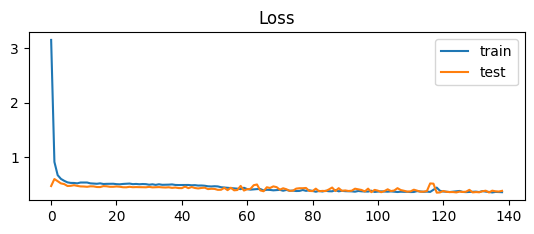

In [ ]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

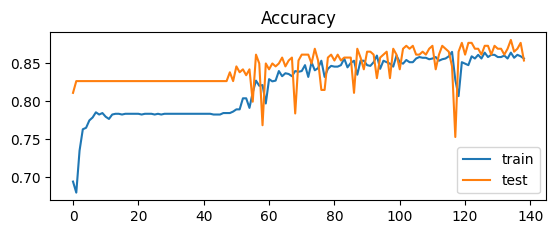

In [ ]:
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

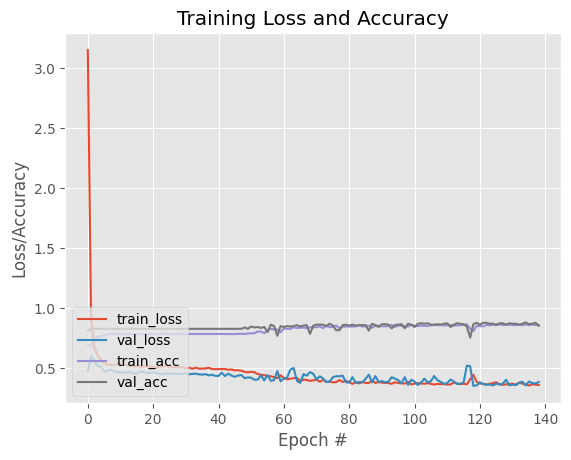

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 139), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 139), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 139), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 139), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [ ]:
# make predictions on the testing set
predict = model.predict(X_test, batch_size=32)

5/5 [==============================] - 0s 5ms/step


In [ ]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predict_labeled = np.argmax(predict, axis=1)

In [ ]:
# show a nicely formatted classification report
print(classification_report(y_test.argmax(axis=1), predict_labeled, target_names=label_dict))

                          precision    recall  f1-score   support

 FirstYearPersistence_no       1.00      0.37      0.54        30
FirstYearPersistence_yes       0.86      1.00      0.92       114

                accuracy                           0.87       144
               macro avg       0.93      0.68      0.73       144
            weighted avg       0.89      0.87      0.84       144



In [ ]:
'''
0	0	1	2	6	2	1	1	2	1	1	59	16	7	1
2.5	2	3	4	6	1	2	2	2	1	3	NaN	NaN	7	1
4.25	3.923077	1	1	6	2	1	1	1	2	3	92	41	9	1
'''

In [ ]:
X_test[0]

array([ 2.18      ,  1.566667  ,  1.        ,  2.        ,  6.        ,
        2.        ,  2.        ,  1.        ,  2.        ,  1.        ,
        2.        , 65.        , 32.55794872,  9.        ])

In [ ]:
row = [0, 0, 1, 2, 6, 2, 1, 1, 2, 1, 1, 59, 16, 7]
y_hat = model.predict([row])
print('Predicted: %s (class=%d)' % (y_hat, y_hat.argmax(axis=1)))

1/1 [==============================] - 0s 125ms/step
Predicted: [[0.8130728  0.18692714]] (class=0)


In [ ]:
row = [2.5, 2, 3, 4, 6, 1, 2, 2, 2, 1, 3, 80, 80, 7]
y_hat = model.predict([row])
print('Predicted: %s (class=%d)' % (y_hat, y_hat.argmax(axis=1)))

1/1 [==============================] - 0s 44ms/step
Predicted: [[0.00173666 0.9982633 ]] (class=1)


In [ ]:
row = [4, 3, 1, 1, 6, 2, 1, 1, 1, 2, 3, 92, 41, 9]
y_hat = model.predict([row])
print('Predicted: %s (class=%d)' % (y_hat, y_hat.argmax(axis=1)))

1/1 [==============================] - 0s 40ms/step
Predicted: [[0.07059525 0.92940474]] (class=1)


In [ ]:
row = [1, 1, 3, 4, 6, 2, 2, 2, 2, 2, 0, 92, 41, 9]
y_hat = model.predict([row])
print('Predicted: %s (class=%d)' % (y_hat, y_hat.argmax(axis=1)))

1/1 [==============================] - 0s 42ms/step
Predicted: [[0.3235028 0.6764972]] (class=1)


# **F. SAVE MODEL**

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('my_last_model.h5')

In [ ]:
# Save Data
print(X_train, type(X_train))

# Convert the NumPy array to a Pandas DataFrame
X_train_df = pd.DataFrame(X_train)
X_val_df = pd.DataFrame(X_val)
X_test_df = pd.DataFrame(X_test)
y_train_df = pd.DataFrame(y_train)
y_val_df = pd.DataFrame(y_val)
y_test_df = pd.DataFrame(y_test)

# Write the data to a CSV file
X_train_df.to_csv('X_train_data_group_acdc.csv',index=False)
X_val_df.to_csv('X_val_data_group_acdc.csv',index=False)
X_test_df.to_csv('X_test_data_group_acdc.csv',index=False)

y_train_df.to_csv('y_train_data_group_acdc.csv',index=False)
y_val_df.to_csv('y_val_data_group_acdc.csv',index=False)
y_test_df.to_csv('y_test_data_group_acdc.csv',index=False)

[[ 2.28        2.42        3.         ... 77.15273775 32.55794872
   8.        ]
 [ 2.8460731   2.82017558  1.         ... 77.15273775 25.
   9.        ]
 [ 2.94        3.25        1.         ... 77.15273775 21.
   9.        ]
 ...
 [ 2.083333    1.763158    1.         ... 77.15273775 32.55794872
   3.        ]
 [ 2.2         1.47619     1.         ... 82.         23.
   7.        ]
 [ 3.020833    2.130435    3.         ... 77.15273775 34.
   8.        ]] <class 'numpy.ndarray'>


In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('my_last_model.h5')

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 14)                210       
                                                                 
 normalization (Normalizatio  (None, 14)               3         
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 300)               4500      
                                                                 
 dense_2 (Dense)             (None, 150)               45150     
                                                                 
 alpha_dropout (AlphaDropout  (None, 150)              0         
 )                                                               
                                                                 
 dense_3 (Dense)             (None, 80)                1

In [ ]:
row = [0, 0, 1, 2, 6, 2, 1, 1, 2, 1, 1, 59, 16, 7]
y_hat = new_model.predict([row])
print('Predicted: %s (class=%d)' % (y_hat, y_hat.argmax(axis=1)))

1/1 [==============================] - 0s 182ms/step
Predicted: [[0.8130728  0.18692714]] (class=0)


In [ ]:
row = [4, 3, 1, 1, 6, 2, 1, 1, 1, 2, 3, 92, 41, 9]
y_hat = new_model.predict([row])
print('Predicted: %s (class=%d)' % (y_hat, y_hat.argmax(axis=1)))

1/1 [==============================] - 0s 162ms/step
Predicted: [[0.07059525 0.92940474]] (class=1)
